# Extra Credit Assignment - Quanwei Gu(quanwei2) & Ziqi Li(ziqili3)

In this notebook file, we built some other adversarial attack methods. Namely,

1. **Iterative Fast Gradient Sign Method** (or Basic Iterative Method - BIM)
2. **Least-Likely Class Method**
3. **Iterative Least-Likely Class Method**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

Again, we use ResNet50 as the pretrained model.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Here, we loaded ResNet as the pretrained model and set it to eval() mode.
model = models.resnet50(pretrained=True).to(device)
model.eval()

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Load and normalize images from the imagenette dataset.

In [ ]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

## Iterative Fast Gradient Sign Method (IFGSM or BIM)

The FGSM and the Targeted FGSM we implemented previously only take one single step when they perform the attack. However, the IFGSM mentioned in this [paper](https://arxiv.org/pdf/1607.02533.pdf) is an extension of the FGSM method. Basically, IFGSM applies FGSM **mutiple times** but it takes a small step during each iteration. That is, during each iteration, IFGSM take one small step in the direction of the gradient.


In [ ]:
# IFGSM Attack
def Iterative_fgsm_attack(model, image, label, epsilon, step_alpha, device, indices):

    # According to the paper https://arxiv.org/pdf/1607.02533.pdf,
    # the number of iterations = min(eps+4, 1.25*eps)
    iterations = int(min(epsilon+4, 1.25*epsilon))
    epsilon = epsilon / 255 #scale eps

    for i in range(iterations):
        image.requires_grad = True

        output = model(image).to(device)[:,indices]
        model.zero_grad()   # Zero all existing gradients

        loss = nn.CrossEntropyLoss()(output, label)
        loss.backward()     # Calculate gradients of model in backward pass

        data_grad = image.grad.data     # Collect datagrad
        temp = image + step_alpha * torch.sign(data_grad) #FGSM

        perturbation = temp - image     #compute the perturbation
        perturbation = torch.clamp(perturbation, -epsilon, epsilon) # clip the grdient to make sure it is in the range of (-eps, eps)
        perturbed_image = image + perturbation     # add perturbation to the image
        image.data = perturbed_image
        
    return image

In [ ]:
# test IFGSM on the pretrained model

# These resources give us some ideas on modifying the hyperparameters:
# https://arxiv.org/pdf/1607.02533.pdf
# https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/bim.html

indices = [0, 217,482, 491,497,566, 569, 571,574,701]
def ifgsm_test( model, device, test_loader):
    # Accuracy counter
    correct = 0
    # epsilons = [4,8,12,16]

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        if i%1000==1:
            print(i-1)
        
        data, target = data.to(device), target.to(device)

        # call IFGSM
        # here we used eps=4, step_alpha=0.003
        perturbed_data = Iterative_fgsm_attack(model, data, target, 4, 0.003, device, indices)
        
        output = model(perturbed_data).to(device)[:, indices] # Re-classify the perturbed image
        
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if final_pred.item() == target.item():
            correct += 1
        else:
            # Save an adv example for visualization later
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            example = (final_pred.item(), adv_ex)
    
    # Calculate test accuracy 
    final_acc = correct/float(len(test_loader))
    print("IFGSM Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))


    # Return the accuracy and an adversarial example
    return final_acc, example

**Results & Findings:**

For this particular setting of hyperparameters of IFGSM, the pretrained model results in a test accuracy around 35% on the validation dataset of Imagenette.
Since the pretrained model ResNet has a test accuracy around 82% when there is no attack, we can conclude that the IFGSM method indeed makes the classifier giving more incorrect results.

In [ ]:
acc, example = ifgsm_test(model, device, dataloader)

0
1000
2000
3000
IFGSM Test Accuracy = 1370 / 3925 = 0.3490445859872611


**Visualize** an adversarial example:

Here, clearly, the object shown in the image is a golf ball, however, the classifier incorrectly predicted it as the 3rd class 'chain saw'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


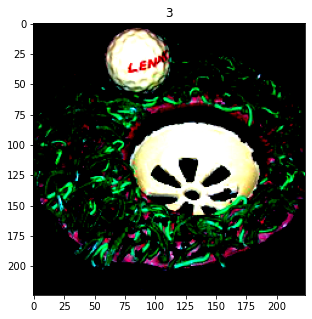

In [ ]:
plt.figure(figsize=(5,5))
adv,ex = example
plt.title(adv)
plt.imshow(ex.transpose((1,2,0)))
plt.show()

## Least-Likely Class Method

Below, we also implemented the Least-Likely Class Method.

Some attacks we have built so far, FGSM and IFGSM, all tried to attack the classifier by increasing the cost of the correct class. The LL-Class Method, proposed in this [paper](https://arxiv.org/pdf/1607.02533.pdf), however, trys to create more interesting mistakes by **minimizing** the loss for the least likely class. Therefore, we used to **add** pertubation to the original input image, now it will **substract** it from the image. 

We noticed that the LL Class Method is actually quite similar to the T-FGSM method. The main difference is that, the T-FGSM pick a random class as the target class, while the LL Class Method takes the least likely one as the target class.

In [ ]:
# LL Class Attack
def LL_attack(model, output, image, epsilon, target_label, device, indices):
    
    loss = F.nll_loss(output, target_label) # compute loss
    model.zero_grad()   # Zero all existing gradients
    loss.backward()     # Calculate gradients of model in backward pass
    data_grad = image.grad.data     # Collect datagrad
    perturbed_image = image - epsilon * torch.sign(data_grad) # substract gradient 
    perturbed_image = torch.clamp(perturbed_image, 0.0, 1.0)
    
    return perturbed_image

In [ ]:
# test the LL Class Method on the pretrained model

def LL_test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        
        # Forward pass the data through the model
        output = model(data).to(device)[:, indices]
        
        _, init_pred = torch.max(output,1) # get the index of the max log-probability
        
        ########################################################
        # Pick the least likely class label as the target label
        target_label = torch.min(output,1)[1]
        target_label = target_label.to(device)
        ########################################################
        
        # Call LL Attack
        perturbed_data = LL_attack(model, output, data, epsilon, target_label, device, indices)

        # Re-classify the perturbed image
        output = model(perturbed_data).to(device)[:, indices]
        
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate test accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Run the LL test for each epsilon and print the accuracies respectively.

In [ ]:
epsilons = [0, .1, .15, 0.5, 0.8]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    print("current eps is: ", eps)
    acc, ex = LL_test(model, device, dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

current eps is:  0
Epsilon: 0	Test Accuracy = 3219 / 3925 = 0.8201273885350319
current eps is:  0.1
Epsilon: 0.1	Test Accuracy = 2896 / 3925 = 0.7378343949044586
current eps is:  0.15
Epsilon: 0.15	Test Accuracy = 2670 / 3925 = 0.6802547770700637
current eps is:  0.5
Epsilon: 0.5	Test Accuracy = 1691 / 3925 = 0.430828025477707
current eps is:  0.8
Epsilon: 0.8	Test Accuracy = 1301 / 3925 = 0.33146496815286625


**Plot** the test accuracies. As shown in the plot below, the test accuracy keeps decresing when epsilon grows, which implies that the classifier predicts more and more images incorrectly.

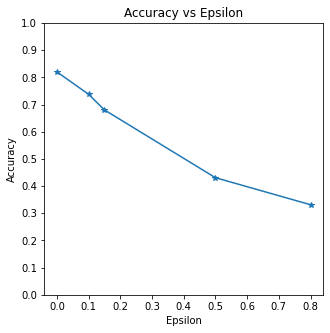

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .85, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Iterative Least-Likely Class Method

The Iterative LL Class Method is an extension of the previous LL Class Method. Essentially, this time we apply the LL Class Method **mutiple times with small steps**. We used the same hyperparameters from the IFGSM in this test.

In [ ]:
# Iterative Least-Likely Class Method

def iterative_LL_attack(model, image, LL_class_label, epsilon, step_alpha, device, indices):

    # the number of iterations = min(eps+4, 1.25*eps)
    iterations = int(min(epsilon+4, 1.25*epsilon))
    epsilon = epsilon / 255 #scale eps
    
    for i in range(iterations):
        image.requires_grad = True
        output = model(image).to(device)[:,indices]
        model.zero_grad()   # Zero all existing gradients
        loss = nn.CrossEntropyLoss()(output, LL_class_label)    #compute loss
        loss.backward()     # Calculate gradients of model in backward pass
        data_grad = image.grad.data     # Collect datagrad
        temp = image - step_alpha * torch.sign(data_grad)  
        perturbation = temp - image
        perturbation = torch.clamp(perturbation, -epsilon, epsilon) # make sure perturbation is in the range of (-eps, eps)
        perturbed_image = image + perturbation
        perturbed_image = torch.clamp(perturbed_image,0.0,1.0)
        image.data = perturbed_image
        
    return image

In [ ]:
# run the Iterative Least-Likely Class Method on the pretrained model

def iterative_LL_test( model, device, test_loader):
    # Accuracy counter
    correct = 0

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        
        output = model(data).to(device)[:, indices]
        _, init_pred = torch.max(output,1) # get the index of the max log-probability

        # Pick the least likely class label as the target label
        LL_class_label = torch.min(output,1)[1]
        LL_class_label = LL_class_label.to(device)
        perturbed_data = iterative_LL_attack(model, data, LL_class_label, 4, 0.003, device, indices)
        
        # Re-classify the perturbed image
        output = model(perturbed_data).to(device)[:, indices]
        
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if final_pred.item() == target.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            example = (init_pred.item(), final_pred.item(), adv_ex)
    
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Iterative LL Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, example

Run the test and print test accuracy. After running the test, the pretrained classifier results in a test accuracy around 19% which is much lower than the 35% test accuracy given by the IFGSM test function. This implies that the Iterative LL Class Method has a larger effect on the classifier compared to the IFGSM Method, and this coincides the findings mentioned in the original [paper](https://arxiv.org/pdf/1607.02533.pdf).  "The least likely class method destroys the correct classification of most images even when epsilon is relatively small," as the paper states.

In [ ]:
iterative_LL_test_acc, example = iterative_LL_test(model, device, dataloader)

Iterative LL Test Accuracy = 735 / 3925 = 0.18726114649681527


**Visualize** an adversarial example

Here, the object in the image is clearly a parachute which is class 9. However, after Iterative LL class attack, the pretrained classifier predicts it as a garbage truck (class 6). These two classes are quite distinct from each other.

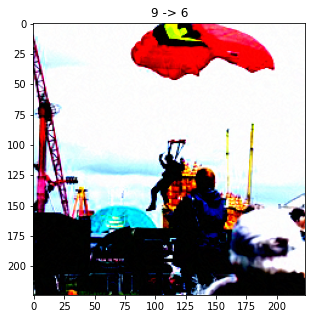

In [ ]:
plt.figure(figsize=(5,5))
orig, adv, ex = example
plt.title("{} -> {}".format(orig, adv))
plt.imshow(ex.transpose((1,2,0)))
plt.show()